<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fsentiment/applications/classification/Sentiment%20Analysis%20with%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!unzip "./drive/My Drive/imdb.zip"

Archive:  ./drive/My Drive/imdb.zip
  inflating: IMDB Dataset.csv        


In [2]:
!ls

sample_data


In [5]:
!pip install transformers

     |████████████████████████████████| 675kB 13.3MB/s 
     |████████████████████████████████| 890kB 18.6MB/s 
     |████████████████████████████████| 1.1MB 50.6MB/s 
     |████████████████████████████████| 3.8MB 48.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=3adeac8443f8ce46495cf287af491f375cf82a188ffcc8a04793e9240b816420
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
from collections import defaultdict

import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
df.shape

(50000, 2)

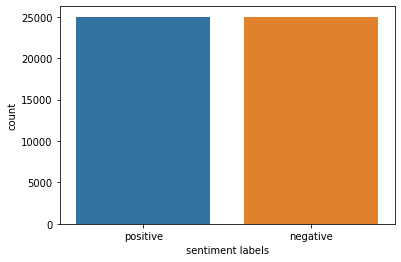

In [11]:
sns.countplot(df.sentiment)
plt.xlabel('sentiment labels');

In [12]:
df["sentiment"] = df["sentiment"].astype('category')
df["labels"] = df["sentiment"].cat.codes
df = df.drop(columns=['sentiment'])
df.head()

,review,labels
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Sample tokenization

In [14]:
sample_txt = """Loved today's show!!! It was a variety and not solely cooking (which would have been great too)."""
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Loved today's show!!! It was a variety and not solely cooking (which would have been great too).
   Tokens: ['loved', 'today', "'", 's', 'show', '!', '!', '!', 'it', 'was', 'a', 'variety', 'and', 'not', 'solely', 'cooking', '(', 'which', 'would', 'have', 'been', 'great', 'too', ')', '.']
Token IDs: [3866, 2651, 1005, 1055, 2265, 999, 999, 999, 2009, 2001, 1037, 3528, 1998, 2025, 9578, 8434, 1006, 2029, 2052, 2031, 2042, 2307, 2205, 1007, 1012]


### Special Tokens

In [15]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


### Sample encoding with special tokens

In [0]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [17]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 3866, 2651, 1005, 1055, 2265,  999,  999,  999, 2009, 2001, 1037,
        3528, 1998, 2025, 9578, 8434, 1006, 2029, 2052, 2031, 2042, 2307, 2205,
        1007, 1012,  102,    0,    0,    0,    0,    0])

In [19]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0]])

### Inverse Tokenization

In [20]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'loved',
 'today',
 "'",
 's',
 'show',
 '!',
 '!',
 '!',
 'it',
 'was',
 'a',
 'variety',
 'and',
 'not',
 'solely',
 'cooking',
 '(',
 'which',
 'would',
 'have',
 'been',
 'great',
 'too',
 ')',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing maximum token length

In [0]:
token_lens = []
for txt in df.review:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

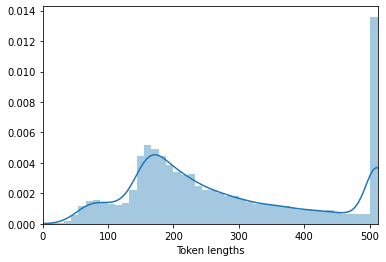

In [29]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token lengths');

In [0]:
del token_lens

In [0]:
MAX_LEN = 256

### Dataset Creation

In [0]:
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        super().__init__()

        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)
    

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [0]:
df_train, df_val = train_test_split(
  df,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [24]:
df_train.shape, df_val.shape

((25000, 2), (25000, 2))

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = IMDBDataset(
        reviews=df.review.to_numpy(),
        labels=df.labels.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        dataset,
        batch_size=batch_size
    )

In [0]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

### Sample data

In [27]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'label'])

In [28]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


In [0]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [30]:
NUM_CLASSES = 2
model = SentimentClassifier(NUM_CLASSES)
model = model.to(device)
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [0]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
def train(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for index, batch in enumerate(data_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    targets = batch["label"].to(device)

    # forward pass
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # loss
    loss = loss_fn(outputs, targets)

    # accuracy
    _, preds = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    # backward pass
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # optimization
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    if index % 100 == 0:
        print(f"processed {index} batches")
  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def evaluation(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
torch.cuda.empty_cache()

In [39]:
history = defaultdict(list)
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    train_acc, train_loss = train(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    val_acc, val_loss = evaluation(model, val_data_loader, loss_fn, device, len(df_val))
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'model.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)


processed 0 batches


KeyboardInterrupt: ignored

In [0]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [0]:
model.load_state_dict(torch.load('model.pt'))

In [0]:
def inference(review_text, model, device):
    encoded_review = tokenizer.encode_plus(
        review_text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    print(f'Review text: {review_text}')
    print(f'Sentiment  : {class_names[prediction]}')

In [0]:
test_review = "I really love the movie"
inference(test_review, model, device)